In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# prepare Kaggle API token in .kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download nikhilpandey360/chest-xray-masks-and-labels
! unzip /content/chest-xray-masks-and-labels.zip

mkdir: cannot create directory ‘/root/.kaggle’: File exists
cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 166, in authenticate
    self.config_file, self.config_dir))
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.
unzip:  cannot find or open /content/chest-xray-masks-and-labels.zip, /content/chest-xray-masks-and-labels.zip.zip or /content/chest-xray-masks-and-labels.zip.ZIP.


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


**Importing Required Libraries**

In [3]:
from __future__ import division
from __future__ import print_function
from __future__ import absolute_import

import numpy as np
import cv2
import os
from sklearn import metrics
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torch.autograd import Variable as V

mask_train_path = 'data/Lung Segmentation/masks'
mask_test_path = 'gdrive/MyDrive/dataset_test/test2/new_aug/image'
image_train_path = 'data/Lung Segmentation/CXR_png'
image_test_path = 'gdrive/MyDrive/dataset_test/test2/new_aug/mask'

**Data Loading and Preprocessing**

In [ ]:
from os.path import exists

def randomHueSaturationValue(image, hue_shift_limit=(-180, 180),
                             sat_shift_limit=(-255, 255),
                             val_shift_limit=(-255, 255), u=0.5):
    if np.random.random() < u:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        h, s, v = cv2.split(image)
        hue_shift = np.random.randint(hue_shift_limit[0], hue_shift_limit[1]+1)
        hue_shift = np.uint8(hue_shift)
        h += hue_shift
        sat_shift = np.random.uniform(sat_shift_limit[0], sat_shift_limit[1])
        s = cv2.add(s, sat_shift)
        val_shift = np.random.uniform(val_shift_limit[0], val_shift_limit[1])
        v = cv2.add(v, val_shift)
        image = cv2.merge((h, s, v))
        #image = cv2.merge((s, v))
        image = cv2.cvtColor(image, cv2.COLOR_HSV2BGR)

    return image

def randomShiftScaleRotate(image, mask,
                           shift_limit=(-0.0, 0.0),
                           scale_limit=(-0.0, 0.0),
                           rotate_limit=(-0.0, 0.0), 
                           aspect_limit=(-0.0, 0.0),
                           borderMode=cv2.BORDER_CONSTANT, u=0.5):
    if np.random.random() < u:
        height, width, channel = image.shape

        angle = np.random.uniform(rotate_limit[0], rotate_limit[1])
        scale = np.random.uniform(1 + scale_limit[0], 1 + scale_limit[1])
        aspect = np.random.uniform(1 + aspect_limit[0], 1 + aspect_limit[1])
        sx = scale * aspect / (aspect ** 0.5)
        sy = scale / (aspect ** 0.5)
        dx = round(np.random.uniform(shift_limit[0], shift_limit[1]) * width)
        dy = round(np.random.uniform(shift_limit[0], shift_limit[1]) * height)

        cc = np.math.cos(angle / 180 * np.math.pi) * sx
        ss = np.math.sin(angle / 180 * np.math.pi) * sy
        rotate_matrix = np.array([[cc, -ss], [ss, cc]])

        box0 = np.array([[0, 0], [width, 0], [width, height], [0, height], ])
        box1 = box0 - np.array([width / 2, height / 2])
        box1 = np.dot(box1, rotate_matrix.T) + np.array([width / 2 + dx, height / 2 + dy])

        box0 = box0.astype(np.float32)
        box1 = box1.astype(np.float32)
        mat = cv2.getPerspectiveTransform(box0, box1)
        image = cv2.warpPerspective(image, mat, (width, height), flags = cv2.INTER_LINEAR, borderMode = borderMode,borderValue = (0, 0,0,))
        mask = cv2.warpPerspective(mask, mat, (width, height), flags = cv2.INTER_LINEAR, borderMode = borderMode, borderValue = (0, 0,0,))

    return image, mask

def randomFlip(image, mask, u=0.5):
    if np.random.random() < u:
        image = cv2.flip(image, 1)
        mask = cv2.flip(mask, 1)

    return image, mask

def randomRotate90(image, mask, u=0.5):
    if np.random.random() < u:
        image=np.rot90(image)
        mask=np.rot90(mask)

    return image, mask
      
def loader(img_path, mask_path, phase):

    img = cv2.imread(img_path)
    img = cv2.resize(img, (448, 448))

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (448, 448))
    
    if(phase == 'train'):
        img = randomHueSaturationValue(img,
                                      hue_shift_limit=(-30, 30),
                                      sat_shift_limit=(-5, 5),
                                      val_shift_limit=(-15, 15))

        img, mask = randomShiftScaleRotate(img, mask,
                                          shift_limit=(-0.1, 0.1),
                                          scale_limit=(-0.1, 0.1),
                                          aspect_limit=(-0.1, 0.1),
                                          rotate_limit=(-0, 0))
        img, mask = randomFlip(img, mask)
        img, mask = randomRotate90(img, mask)

    img = np.array(img, np.float32).transpose(2,0,1)/255.0 
    mask = np.array(mask, np.float32)
    mask = mask[np.newaxis,:,:]
    mask = mask/255.0
    mask[mask >= 0.5] = 1
    mask[mask < 0.5] = 0
    
    return img, mask


def read_dataset(root_path, mode='train'):

    images = []
    masks = []
    if mode == 'train':
        image_root = os.path.join(root_path, image_train_path)
        gt_root = os.path.join(root_path, mask_train_path)
    else:
        image_root = os.path.join(root_path, image_test_path)
        gt_root = os.path.join(root_path, mask_test_path)

    for image_name in os.listdir(image_root):
        image_path = os.path.join(image_root, image_name.split('.')[0] + '.png')
        label_path = os.path.join(gt_root, image_name.split('.')[0] + '.png')
        if exists(image_path) and exists(label_path):
            images.append(image_path)
            masks.append(label_path)
        elif exists(image_path) and exists(label_path[:len(label_path) - 4] + '_mask.png'):
            images.append(image_path)
            masks.append(label_path[:len(label_path) - 4] + '_mask.png')


    # print(images, masks)

    return images, masks

class Lung_Dataset(Dataset):

    def __init__(self, root_path, phase='train'):
        self.root = root_path
        self.phase = phase
        self.images, self.labels = read_dataset(self.root, self.phase)

    def __getitem__(self, index):

        img, mask = loader(self.images[index], self.labels[index], self.phase)
        img = torch.tensor(img, dtype = torch.float32)
        mask = torch.tensor(mask, dtype = torch.float32)
        if self.phase == 'train':
          return img, mask
        else:
          return img, mask, self.images[index].split('/')[-1]

    def __len__(self):
        assert len(self.images) == len(self.labels), 'The number of images must be equal to labels'
        return len(self.images)

**Context Encoder Architecture**

In [ ]:
# Dilated Atrous Convolution

class DAC(nn.Module):
    
    def __init__(self,channels):
        
        super(DAC, self).__init__()
        self.conv11 = nn.Conv2d(channels, channels, kernel_size = 3, dilation = 1, padding = 1)
        
        self.conv21 = nn.Conv2d(channels, channels, kernel_size = 3, dilation = 3, padding = 3)
        self.conv22 = nn.Conv2d(channels, channels, kernel_size = 1, dilation = 1, padding = 0)
        
        self.conv31 = nn.Conv2d(channels, channels, kernel_size = 3, dilation = 1, padding = 1)
        self.conv32 = nn.Conv2d(channels, channels, kernel_size = 3, dilation = 3, padding = 3)
        self.conv33 = nn.Conv2d(channels, channels, kernel_size = 1, dilation = 1, padding = 0)
        
        self.conv41 = nn.Conv2d(channels, channels, kernel_size = 3, dilation = 1, padding = 1)
        self.conv42 = nn.Conv2d(channels, channels, kernel_size = 3, dilation = 3, padding = 3)
        self.conv43 = nn.Conv2d(channels, channels, kernel_size = 3, dilation = 5, padding = 5)
        self.conv44 = nn.Conv2d(channels, channels, kernel_size = 1, dilation = 1, padding = 0)
        
    def forward(self, x):
        
        c1 = F.relu(self.conv11(x))
        
        c2 = self.conv21(x)
        c2 = F.relu(self.conv22(c2))
        
        c3 = self.conv31(x)
        c3 = self.conv32(c3)
        c3 = F.relu(self.conv33(c3))
        
        c4 = self.conv41(x)
        c4 = self.conv42(c4)
        c4 = self.conv43(c4)
        c4 = F.relu(self.conv44(c4))
        
        c = x + c1 + c2 + c3 + c4 
        
        return c

# Residual Multi Kernel Pooling

class RMP(nn.Module):
    
    def __init__(self,channels):
        super(RMP, self).__init__()

        self.max1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.conv1 = nn.Conv2d(channels, 1, kernel_size = 1)
        
        self.max2 = nn.MaxPool2d(kernel_size = 3, stride = 3)
        self.conv2 = nn.Conv2d(channels, 1, kernel_size = 1)
        
        self.max3 = nn.MaxPool2d(kernel_size = 5, stride = 5)
        self.conv3 = nn.Conv2d(channels, 1, kernel_size = 1)
       
        self.max4 = nn.MaxPool2d(kernel_size = 6)
        self.conv4 = nn.Conv2d(channels, 1, kernel_size = 1)
        
    def forward(self, x):
        
        m1 = self.max1(x)
        m1 = F.interpolate(self.conv1(m1), size = x.size()[2:], mode = 'bilinear' )
        
        m2 = self.max2(x)
        m2 = F.interpolate(self.conv2(m2), size = x.size()[2:], mode = 'bilinear' )
        
        m3 = self.max3(x)
        m3 = F.interpolate(self.conv3(m3), size = x.size()[2:], mode = 'bilinear' )
        
        m4 = self.max4(x)
        m4 = F.interpolate(self.conv4(m4), size = x.size()[2:], mode = 'bilinear' )
        
        m = torch.cat([m1,m2,m3,m4,x], axis = 1)
        
        return m
        
# Decoder Architecture

class Decoder(nn.Module):
    def __init__(self, in_channels, n_filters):
        super(Decoder, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, in_channels // 4, 1)
        self.bn1 = nn.BatchNorm2d(in_channels // 4)

        self.deconv2 = nn.ConvTranspose2d(in_channels // 4, in_channels // 4, 3, stride=2, padding=1, output_padding=1)
        self.bn2 = nn.BatchNorm2d(in_channels // 4)

        self.conv3 = nn.Conv2d(in_channels // 4, n_filters, 1)
        self.bn3 = nn.BatchNorm2d(n_filters)

    def forward(self, x):

        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.deconv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))

        return x

# Main Architecture   

class CE_Net_(nn.Module):
    def __init__(self, num_classes = 1, num_channels=3):
        super(CE_Net_, self).__init__()

        filters = [64, 128, 256, 512]
        resnet = models.resnet34(pretrained=True)
        self.conv1 = resnet.conv1
        self.bn1 = resnet.bn1
        self.maxpool1 = resnet.maxpool

        self.encoder1 = resnet.layer1
        self.encoder2 = resnet.layer2
        self.encoder3 = resnet.layer3
        self.encoder4 = resnet.layer4

        self.dac = DAC(512)
        self.rmp = RMP(512)

        self.decoder4 = Decoder(516, filters[2])
        self.decoder3 = Decoder(filters[2], filters[1])
        self.decoder2 = Decoder(filters[1], filters[0])
        self.decoder1 = Decoder(filters[0], filters[0])

        self.finaldeconv1 = nn.ConvTranspose2d(filters[0], 32, 4, 2, 1)
        self.finalconv2 = nn.Conv2d(32, num_classes, 3, padding=1)

    def forward(self, x):
        # Encoder
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.maxpool1(x)

        e1 = self.encoder1(x)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)
        e4 = self.encoder4(e3)

        # Center
        e4 = self.dac(e4)
        e4 = self.rmp(e4)

        # Decoder
        d4 = self.decoder4(e4) + e3
        d3 = self.decoder3(d4) + e2
        d2 = self.decoder2(d3) + e1
        d1 = self.decoder1(d2)

        out = F.relu(self.finaldeconv1(d1))
        out = self.finalconv2(out)

        return torch.sigmoid(out)

**Constants**

In [ ]:
root_path = '.'
input_size = (3,448,448)
batch_size = 8
learning_rate = 0.0002
epochs = 100

INITAL_EPOCH_LOSS = 10000
NUM_EARLY_STOP = 20
NUM_UPDATE_LR = 10

device = torch.device('cuda') 

**Dice Coefficient binary cross entropy Loss Function**

In [ ]:
class dice_bce_loss(nn.Module):
    def __init__(self, batch=True):
        super(dice_bce_loss, self).__init__()
        self.batch = batch
        self.bce_loss = nn.BCELoss()

    def soft_dice_coeff(self, y_true, y_pred):
        smooth = 0.0  # may change
        if self.batch:
            i = torch.sum(y_true)
            j = torch.sum(y_pred)
            intersection = torch.sum(y_true * y_pred)
        else:
            i = y_true.sum(1).sum(1).sum(1)
            j = y_pred.sum(1).sum(1).sum(1)
            intersection = (y_true * y_pred).sum(1).sum(1).sum(1)
        score = (2. * intersection + smooth) / (i + j + smooth)
        # score = (intersection + smooth) / (i + j - intersection + smooth)#iou
        return score.mean()

    def soft_dice_loss(self, y_true, y_pred):
        loss = 1 - self.soft_dice_coeff(y_true, y_pred)
        return loss

    def __call__(self, y_true, y_pred):
        a = self.bce_loss(y_pred, y_true)
        b = self.soft_dice_loss(y_true, y_pred)
        return a



**Accuracy and Sensitivity**

In [ ]:
def acc_sen(pred, mask) :

    pred = torch.round(pred)
    TP = (mask * pred).sum(1).sum(1).sum(1)
    TN = ((1 - mask) * (1 - pred)).sum(1).sum(1).sum(1)
    FP = pred.sum(1).sum(1).sum(1) - TP
    FN = mask.sum(1).sum(1).sum(1) - TP
    acc = (TP + TN)/ (TP + TN + FP + FN)
    acc = torch.sum(acc)

    sen = TP / (TP + FN)
    sen = torch.sum(sen)
    return acc, sen


**Frame work**

In [ ]:
class MyFrame():
    def __init__(self, net, learning_rate, device, evalmode=False):
        self.net = net().to(device)
        self.optimizer = torch.optim.Adam(params=self.net.parameters(), lr=learning_rate)
        self.loss = dice_bce_loss().to(device)
        self.lr = learning_rate
        
    def set_input(self, img_batch, mask_batch=None):
        self.img = img_batch
        self.mask = mask_batch
        
    def optimize(self):

        self.optimizer.zero_grad()
        pred = self.net.forward(self.img)
        loss = self.loss(self.mask, pred)
        loss.backward()
        self.optimizer.step()
        return loss, pred
        
    def save(self, path):
        torch.save(self.net.state_dict(), path)
        
    def load(self, path):
        self.net.load_state_dict(torch.load(path))

    def update_lr(self, new_lr, factor=False):

        if factor:
            new_lr = self.lr / new_lr
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = new_lr

        print ('update learning rate: %f -> %f' % (self.lr, new_lr))
        print ('update learning rate: %f -> %f' % (self.lr, new_lr))
        self.lr = new_lr

**Main**

In [ ]:
model_out_path = '/content/gdrive/MyDrive/dsw/final_cenet_weights.th'

In [ ]:
train_dataset = Lung_Dataset(root_path = root_path, phase = 'train')
train_loader = DataLoader(train_dataset, batch_size = 8, shuffle = True)

In [ ]:
solver = MyFrame(CE_Net_, learning_rate, device)
no_optim = 0
train_epoch_best_loss = INITAL_EPOCH_LOSS
Loss = [] 
Accuracy = []
Sensitivity = []
epochs = 30
for epoch in range(1, epochs + 1):
    print('Epoch {}/{}'.format(epoch, epochs))
    train_epoch_loss = 0
    train_epoch_acc = 0
    train_epoch_sen = 0

    # index = 0
    length = len(train_loader)
    iterator = tqdm(enumerate(train_loader), total=length, leave=False, desc=f'Epoch {epoch}/{epochs}')
    for index, (img, mask) in iterator :

        img = img.to(device)
        mask = mask.to(device)

        solver.set_input(img, mask)
        train_loss, pred = solver.optimize()
        train_acc, train_sen = acc_sen(pred,mask)
        train_loss = train_loss.detach().cpu().numpy()
        train_acc = train_acc.detach().cpu().numpy()
        train_sen = train_sen.detach().cpu().numpy()

        train_epoch_loss += train_loss
        train_epoch_acc += train_acc
        train_epoch_sen += train_sen
        # index = index + 1
        # print(index, end = ' ')

    train_epoch_loss = train_epoch_loss/len(train_loader)
    train_epoch_acc = train_epoch_acc/len(train_dataset)
    train_epoch_sen = train_epoch_sen/len(train_dataset)

    print('train_loss:', train_epoch_loss)
    print('train_accuracy:', train_epoch_acc)
    print('train_sensitivity:', train_epoch_sen)

    Loss.append(train_epoch_loss)
    Accuracy.append(train_epoch_acc)
    Sensitivity.append(train_epoch_sen)
    
    solver.save(model_out_path)

    if train_epoch_loss >= train_epoch_best_loss:
        no_optim += 1
    else:
        no_optim = 0
        train_epoch_best_loss = train_epoch_loss
        solver.save(model_out_path)

    if no_optim > NUM_UPDATE_LR:
        if solver.lr < 1e-9:
            break
        solver.load(model_out_path)
        solver.update_lr(2.0, factor=True)

    if no_optim > NUM_EARLY_STOP:
        print('early stop at %d epoch' % epoch)
        print('early stop at %d epoch' % epoch)
        break
    

    print('---------------------------------------------')

Epoch 1/30


Epoch 1/30:   0%|          | 0/88 [00:00<?, ?it/s]

train_loss: 0.36211310276253655
train_accuracy: 0.7831843993203207
train_sensitivity: 0.1998377057515923
---------------------------------------------
Epoch 2/30


Epoch 2/30:   0%|          | 0/88 [00:00<?, ?it/s]

train_loss: 0.11426771055399017
train_accuracy: 0.9768891883167353
train_sensitivity: 0.950770379467444
---------------------------------------------
Epoch 3/30


Epoch 3/30:   0%|          | 0/88 [00:00<?, ?it/s]

train_loss: 0.059392696881497446
train_accuracy: 0.9795011356472969
train_sensitivity: 0.9541732397946444
---------------------------------------------
Epoch 4/30


Epoch 4/30:   0%|          | 0/88 [00:00<?, ?it/s]

train_loss: 0.05335077120583843
train_accuracy: 0.980783686041832
train_sensitivity: 0.9553214453838088
---------------------------------------------
Epoch 5/30


Epoch 5/30:   0%|          | 0/88 [00:00<?, ?it/s]

train_loss: 0.05846395550973036
train_accuracy: 0.979032190008597
train_sensitivity: 0.9519201401959766
---------------------------------------------
Epoch 6/30


Epoch 6/30:   0%|          | 0/88 [00:00<?, ?it/s]

train_loss: 0.05162557879124175
train_accuracy: 0.9811046753417362
train_sensitivity: 0.955580351704901
---------------------------------------------
Epoch 7/30


Epoch 7/30:   0%|          | 0/88 [00:00<?, ?it/s]

train_loss: 0.04911567965014414
train_accuracy: 0.9817376360297203
train_sensitivity: 0.9572269110517069
---------------------------------------------
Epoch 8/30


Epoch 8/30:   0%|          | 0/88 [00:00<?, ?it/s]

train_loss: 0.048658672318031844
train_accuracy: 0.9817135225642811
train_sensitivity: 0.9568689953197133
---------------------------------------------
Epoch 9/30


Epoch 9/30:   0%|          | 0/88 [00:00<?, ?it/s]

train_loss: 0.048672939904711464
train_accuracy: 0.9815331514586102
train_sensitivity: 0.9572714736515825
---------------------------------------------
Epoch 10/30


Epoch 10/30:   0%|          | 0/88 [00:00<?, ?it/s]

train_loss: 0.04905068597079001
train_accuracy: 0.9814729406075045
train_sensitivity: 0.9565818601033904
---------------------------------------------
Epoch 11/30


Epoch 11/30:   0%|          | 0/88 [00:00<?, ?it/s]

train_loss: 0.04763820680620318
train_accuracy: 0.9818541800433939
train_sensitivity: 0.9579634165221994
---------------------------------------------
Epoch 12/30


Epoch 12/30:   0%|          | 0/88 [00:00<?, ?it/s]

train_loss: 0.04680416292764924
train_accuracy: 0.98205527798696
train_sensitivity: 0.9578457244417884
---------------------------------------------
Epoch 13/30


Epoch 13/30:   0%|          | 0/88 [00:00<?, ?it/s]

train_loss: 0.04655078724450008
train_accuracy: 0.9822442463853143
train_sensitivity: 0.9589601253921335
---------------------------------------------
Epoch 14/30


Epoch 14/30:   0%|          | 0/88 [00:00<?, ?it/s]

train_loss: 0.046545185974206434
train_accuracy: 0.9821059879931536
train_sensitivity: 0.9580548276955431
---------------------------------------------
Epoch 15/30


Epoch 15/30:   0%|          | 0/88 [00:00<?, ?it/s]

train_loss: 0.04488019494932483
train_accuracy: 0.9826570281928236
train_sensitivity: 0.9592145749113776
---------------------------------------------
Epoch 16/30


Epoch 16/30:   0%|          | 0/88 [00:00<?, ?it/s]

train_loss: 0.04508244318210266
train_accuracy: 0.9826445654034615
train_sensitivity: 0.9593566906723109
---------------------------------------------
Epoch 17/30


Epoch 17/30:   0%|          | 0/88 [00:00<?, ?it/s]

train_loss: 0.0443404891570522
train_accuracy: 0.9828808131543073
train_sensitivity: 0.9600716483863917
---------------------------------------------
Epoch 18/30


Epoch 18/30:   0%|          | 0/88 [00:00<?, ?it/s]

train_loss: 0.04378182673826814
train_accuracy: 0.9827994853258133
train_sensitivity: 0.9602175747806375
---------------------------------------------
Epoch 19/30


Epoch 19/30:   0%|          | 0/88 [00:00<?, ?it/s]

train_loss: 0.044092674676159564
train_accuracy: 0.9827717745845969
train_sensitivity: 0.9599668315865777
---------------------------------------------
Epoch 20/30


Epoch 20/30:   0%|          | 0/88 [00:00<?, ?it/s]

train_loss: 0.04374565977857194
train_accuracy: 0.9829044951633974
train_sensitivity: 0.9602717689492486
---------------------------------------------
Epoch 21/30


Epoch 21/30:   0%|          | 0/88 [00:00<?, ?it/s]

train_loss: 0.04241154400039126
train_accuracy: 0.9832055859945037
train_sensitivity: 0.9617878435687586
---------------------------------------------
Epoch 22/30


Epoch 22/30:   0%|          | 0/88 [00:00<?, ?it/s]

train_loss: 0.04400591804137961
train_accuracy: 0.9827650887044993
train_sensitivity: 0.9607688703320243
---------------------------------------------
Epoch 23/30


Epoch 23/30:   0%|          | 0/88 [00:00<?, ?it/s]

train_loss: 0.04302227490750903
train_accuracy: 0.9830326681787317
train_sensitivity: 0.961028519001874
---------------------------------------------
Epoch 24/30


Epoch 24/30:   0%|          | 0/88 [00:00<?, ?it/s]

train_loss: 0.04169175945307044
train_accuracy: 0.9833087860183283
train_sensitivity: 0.9622619314627214
---------------------------------------------
Epoch 25/30


Epoch 25/30:   0%|          | 0/88 [00:00<?, ?it/s]

train_loss: 0.04234350043010305
train_accuracy: 0.983333018693057
train_sensitivity: 0.9618741063909098
---------------------------------------------
Epoch 26/30


Epoch 26/30:   0%|          | 0/88 [00:00<?, ?it/s]

train_loss: 0.04200898201882162
train_accuracy: 0.9834635982459242
train_sensitivity: 0.9627224220470949
---------------------------------------------
Epoch 27/30


Epoch 27/30:   0%|          | 0/88 [00:00<?, ?it/s]

train_loss: 0.042140099346976385
train_accuracy: 0.9833365265618671
train_sensitivity: 0.962221390821717
---------------------------------------------
Epoch 28/30


Epoch 28/30:   0%|          | 0/88 [00:00<?, ?it/s]

train_loss: 0.04164948077364401
train_accuracy: 0.983497985384681
train_sensitivity: 0.9630872078917243
---------------------------------------------
Epoch 29/30


Epoch 29/30:   0%|          | 0/88 [00:00<?, ?it/s]

train_loss: 0.0421123198995536
train_accuracy: 0.9831230721690438
train_sensitivity: 0.9621087028221651
---------------------------------------------
Epoch 30/30


Epoch 30/30:   0%|          | 0/88 [00:00<?, ?it/s]

train_loss: 0.041625196262347425
train_accuracy: 0.9834694198586724
train_sensitivity: 0.9625184644352306
---------------------------------------------


In [ ]:
test_dataset = Lung_Dataset(root_path = root_path, phase = 'test')
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle = False)

test_acc = 0
test_sen = 0

# solver = MyFrame(CE_Net_, learning_rate, device)
# solver.load('final_cenet_weights.th')

model = CE_Net_().to(device)
weights = torch.load(model_out_path))
model.load_state_dict(weights)

<All keys matched successfully>

In [ ]:
import torch

class DiceCoefficient(torch.autograd.Function):
    """
    Dice coefficient for individual examples
        Dice coefficient = 2 * |X n Y| / (|X| + |Y|)
                         = 1 / ( 1/Precision + 1/Recall)
    """
    def forward(self, input , target):
        self.save_for_backward(input, target)
        eps = 1e-10
        self.inter = torch.dot(input.view(-1), target.view(-1)) # inter = |X n Y|
        self.union = torch.sum(input) + torch.sum(target) # union =|X| + |Y|

        dice = 2 * self.inter.float() / (self.union.float() + eps)
        return dice

    def backward(self,grad_output):

        input,target = self.saved_variables
        if self.needs_input_grad[0]:
            grad_input = grad_output * 2 * (target * self.union - self.inter) / ( self.union * self.union )

        if self.needs_input_grad[1]:
            grad_target = None

        return grad_input, grad_target

def dice_coefficient(input, target):
    """Dice coeff for batches"""
    if input.is_cuda:
        s = torch.FloatTensor(1).cuda().zero_()
    else:
        s = torch.FloatTensor(1).zero_()

    for i , c in enumerate(zip(input, target)):
        s += DiceCoefficient().forward(c[0],c[1])

    n_data = len(input)
    return s / n_data

In [ ]:
import matplotlib.pyplot as plt

prediction_out_path = '/content/gdrive/MyDrive/dataset_test/out/'

with torch.no_grad() : 
    for index, (img, mask, name) in tqdm(enumerate(test_loader), total=len(test_loader)):

        img = img.to(device)
        mask = mask.to(device)

        # solver.set_input(img, mask)
        # solver.set_input(img, mask)
        pred = model.forward(img)

        # pred = pred.detach().cpu().numpy()
        acc, sen = acc_sen(pred, mask)
        test_acc += acc
        test_sen += sen

        pred = torch.round(pred)
        pred = pred.detach().cpu().numpy()
        plt.imsave(f'{prediction_out_path}/{name[0]}', pred[0,0])

        # print(index, end = ' ')
    test_acc = test_acc / len(test_dataset)
    test_sen = test_sen / len(test_dataset)

    test_acc = test_acc.detach().cpu().numpy()
    test_sen = test_sen.detach().cpu().numpy()

    print('Test Accuracy : ', test_acc)
    print('Test Sensitivity : ', test_sen)

  0%|          | 0/4832 [00:00<?, ?it/s]

Test Accuracy :  0.9604167
Test Sensitivity :  0.9193758


  0%|          | 0/4128 [00:00<?, ?it/s]

Mean dice coeff: 0.9492909943790465 (on 4128 samples)


Text(0.04, 0.5, 'number of samples')

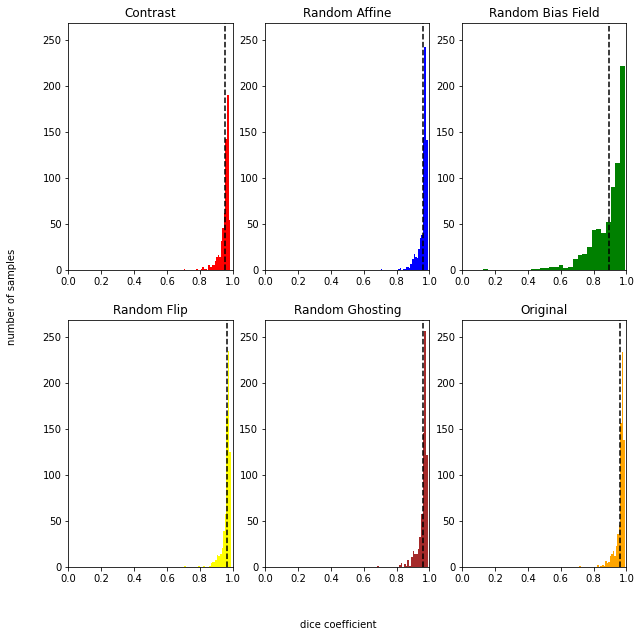

In [ ]:
from pathlib import Path
from os import listdir
from PIL import Image
from numpy import asarray, multiply, sum, arange, mean
import matplotlib.pyplot as plt
from os.path import exists


def dice_coef(y_true, y_pred):
    y_true_f = y_true.flatten()/255
    y_pred_f = y_pred.flatten()/255
    intersection = multiply(y_true_f, y_pred_f)
    intersection = sum(intersection)
    return (2. * intersection + 1) / (sum(y_true_f) + sum(y_pred_f) + 1)


predicted_path = Path(prediction_out_path)
truth_path = Path(mask_test_path)
size = (448, 448)

augtype_to_file_prefix = [
    'Contrast',
    'RandomAffine',
    'RandomBiasField',
    'RandomFlip',
    'RandomGhosting',
    'Original'  
]
augtype_to_description = [
    'Contrast',
    'Random Affine',
    'Random Bias Field',
    'Random Flip',
    'Random Ghosting',
    'Original'
]
augtype_to_color = [
    'red',
    'blue',
    'green',
    'yellow',
    'brown',
    'orange'
]

predicted_list = [p for p in listdir(predicted_path)]
truth_list = listdir(truth_path)

input = []
target = []
augtypes = []

for path in predicted_list:
    path = str(path)

    inp = f'{prediction_out_path}/{path}'
    if exists(f'{mask_test_path}/{path}'):
      tar = f'{mask_test_path}/{path}'
    elif exists(f'{mask_test_path}/{path[:-4]}_mask.png'):
      tar = f'{mask_test_path}/{path[:-4]}_mask.png'
    else:
      continue

    augtype = None
    for a, prefix in enumerate(augtype_to_file_prefix):
        if prefix == path[:len(prefix)]:
            augtype = a
            break
    if augtype is None:
      continue
    augtypes.append(augtype)
    input.append(inp)
    target.append(tar)

augtype_to_results = [[] for _ in range(6)]

mean_coeff = 0
for i, t, a in tqdm(zip(input, target, augtypes), total=len(input)):
    i = asarray(Image.open(i).resize(size).convert('L'))
    t = asarray(Image.open(t).resize(size).convert('L'))
    res = dice_coef(i, t)
    mean_coeff += res
    augtype_to_results[a].append(res)

mean_coeff /= len(input)
print(f"Mean dice coeff: {mean_coeff} (on {len(input)} samples)")
fig, axs = plt.subplots(2, 3, figsize=(10,10))

for i in [0,1]:
    for j in [0,1,2]:
        a = i*3+j
        axs[i,j].hist(augtype_to_results[a], bins=30, color=augtype_to_color[a])
        axs[i,j].set_title(augtype_to_description[a])

max_top_ylim = max([axs[i,j].get_ylim()[1] for i in [0,1] for j in [0,1,2]])

for i in [0,1]:
    for j in [0,1,2]:
        a = i*3+j
        axs[i,j].set_ylim((0, max_top_ylim))
        axs[i,j].set_xlim((0.0, 1.0))
        axs[i,j].vlines(mean(augtype_to_results[a]), 0.0, max_top_ylim, colors='k', linestyles='dashed')

fig.text(0.5, 0.04, 'dice coefficient', ha='center')
fig.text(0.04, 0.5, 'number of samples', va='center', rotation='vertical')

In [ ]:
fig.savefig('comparison.pdf')

In [ ]:
for inp in input:
  a = np.round(np.array(Image.open(inp).resize(size).convert('L'))/255)
  plt.imsave(inp, a, cmap='gray')

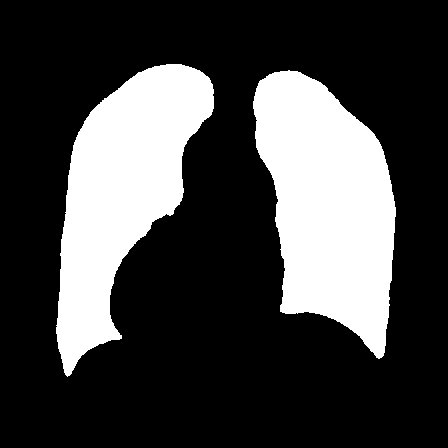

In [ ]:
Image.open(input[20]).resize(size).convert('L')

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(10,10))

for i in [0,1]:
    for j in [0,1,2]:
        a = i*3+j
        axs[i,j].hist(augtype_to_results[a], bins=30, color=augtype_to_color[a])
        axs[i,j].set_title(augtype_to_description[a])

max_top_ylim = max([axs[i,j].get_ylim()[1] for i in [0,1] for j in [0,1,2]])

for i in [0,1]:
    for j in [0,1,2]:
        a = i*3+j
        axs[i,j].set_ylim((0, max_top_ylim))
        axs[i,j].set_xlim((0.0, 1.0))
        axs[i,j].vlines(mean(augtype_to_results[a]), 0.0, max_top_ylim, colors='k', linestyles='dashed')

fig.text(0.5, 0.04, 'dice coefficient', ha='center')
fig.text(0.04, 0.5, 'number of samples', va='center', rotation='vertical')